In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

print("Libraries imported.")

Libraries imported.


In [4]:
from sklearn.datasets import fetch_openml # Import fetch_openml instead of fetch_mnist
import numpy as np

mnist = fetch_openml(name='mnist_784', data_home='./datasets', as_frame=False) # Use fetch_openml with dataset name and as_frame=False
X_mnist, y_mnist = mnist.data.astype('float32') / 255.0, mnist.target.astype('int') # Normalize to [0, 1]

def add_gaussian_noise(images, noise_level=0.3):
    noisy_images = images + noise_level * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images

noise_level = 0.3 # Set noise level here
noisy_mnist_data = add_gaussian_noise(X_mnist, noise_level=noise_level)

n_samples_mnist, n_features_mnist = noisy_mnist_data.shape
image_shape_mnist = (28, 28) # MNIST images are 28x28

print("Noisy MNIST dataset generated.")
print("Number of samples:", n_samples_mnist)
print("Number of features per sample:", n_features_mnist)
print("Image shape:", image_shape_mnist)
print("Noise level (Gaussian scale):", noise_level)

# Center the Noisy MNIST data
noisy_mnist_centered = noisy_mnist_data - noisy_mnist_data.mean(axis=0)

Noisy MNIST dataset generated.
Number of samples: 70000
Number of features per sample: 784
Image shape: (28, 28)
Noise level (Gaussian scale): 0.3


In [5]:
n_components_pca_mnist = 150 # Number of components for PCA

pca_mnist = PCA(n_components=n_components_pca_mnist)
pca_mnist.fit(noisy_mnist_centered) # Fit PCA on centered noisy MNIST

noisy_mnist_pca_reduced = pca_mnist.transform(noisy_mnist_centered)
noisy_mnist_pca_reconstructed = pca_mnist.inverse_transform(noisy_mnist_pca_reduced)

print("PCA implemented on Noisy MNIST and data transformed/reconstructed.")
print("Explained variance ratio by PCA (first 5 components):", pca_mnist.explained_variance_ratio_[:5])

PCA implemented on Noisy MNIST and data transformed/reconstructed.
Explained variance ratio by PCA (first 5 components): [0.05265613 0.0389953  0.03358469 0.02951876 0.02681935]


In [6]:
n_components_pod_mnist = 150 # Number of components for POD

# POD via SVD on centered noisy MNIST
U_mnist, S_mnist, V_mnist = np.linalg.svd(noisy_mnist_centered)

U_reduced_mnist = U_mnist[:, :n_components_pod_mnist]
S_reduced_mnist = np.diag(S_mnist[:n_components_pod_mnist])
V_reduced_mnist = V_mnist[:n_components_pod_mnist, :]

noisy_mnist_pod_reconstructed = np.dot(U_reduced_mnist, np.dot(S_reduced_mnist, V_reduced_mnist))

print("POD (via SVD) implemented on Noisy MNIST and data reconstructed.")
print("Singular values (first 5):", S_mnist[:5])

POD (via SVD) implemented on Noisy MNIST and data reconstructed.
Singular values (first 5): [461.25530638 396.93836198 368.37283263 345.35519606 329.18573454]


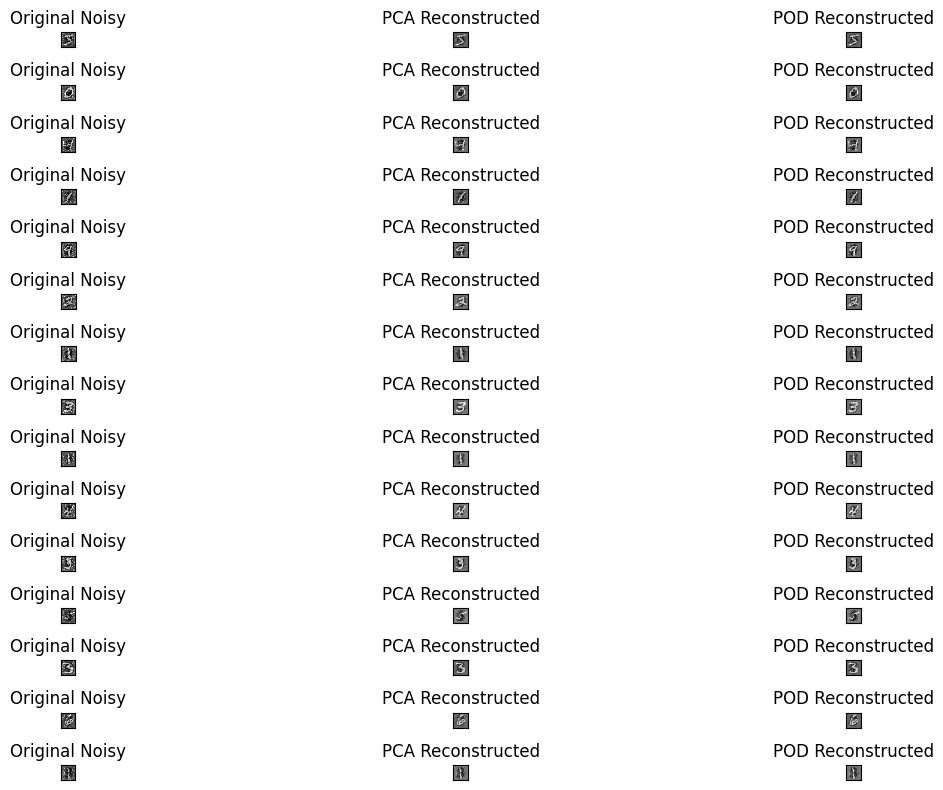

In [7]:
def plot_digits(original_digits, reconstructed_digits_pca, reconstructed_digits_pod, image_shape, n_row=3, n_col=5):
    plt.figure(figsize=(15, 8))
    for i in range(n_row * n_col):
        plt.subplot(n_row * n_col, 3, 3*i + 1)
        plt.imshow(original_digits[i].reshape(image_shape), cmap='gray', interpolation='nearest') # cmap='gray' for MNIST
        plt.xticks(())
        plt.yticks(())
        plt.title('Original Noisy')

        plt.subplot(n_row * n_col, 3, 3*i + 2)
        plt.imshow(reconstructed_digits_pca[i].reshape(image_shape), cmap='gray', interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
        plt.title('PCA Reconstructed')

        plt.subplot(n_row * n_col, 3, 3*i + 3)
        plt.imshow(reconstructed_digits_pod[i].reshape(image_shape), cmap='gray', interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
        plt.title('POD Reconstructed')
    plt.tight_layout()
    plt.show()

plot_digits(noisy_mnist_centered, noisy_mnist_pca_reconstructed, noisy_mnist_pod_reconstructed, image_shape_mnist)

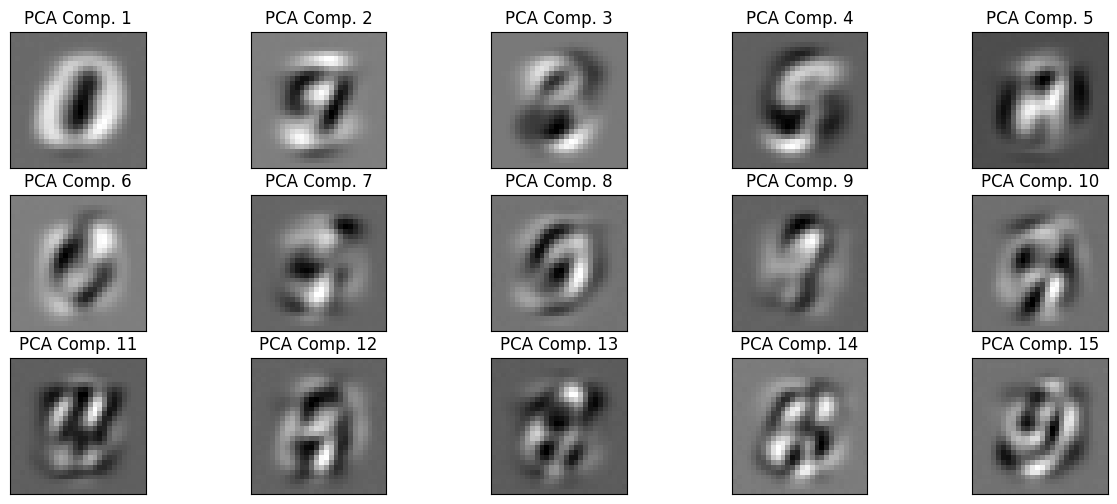

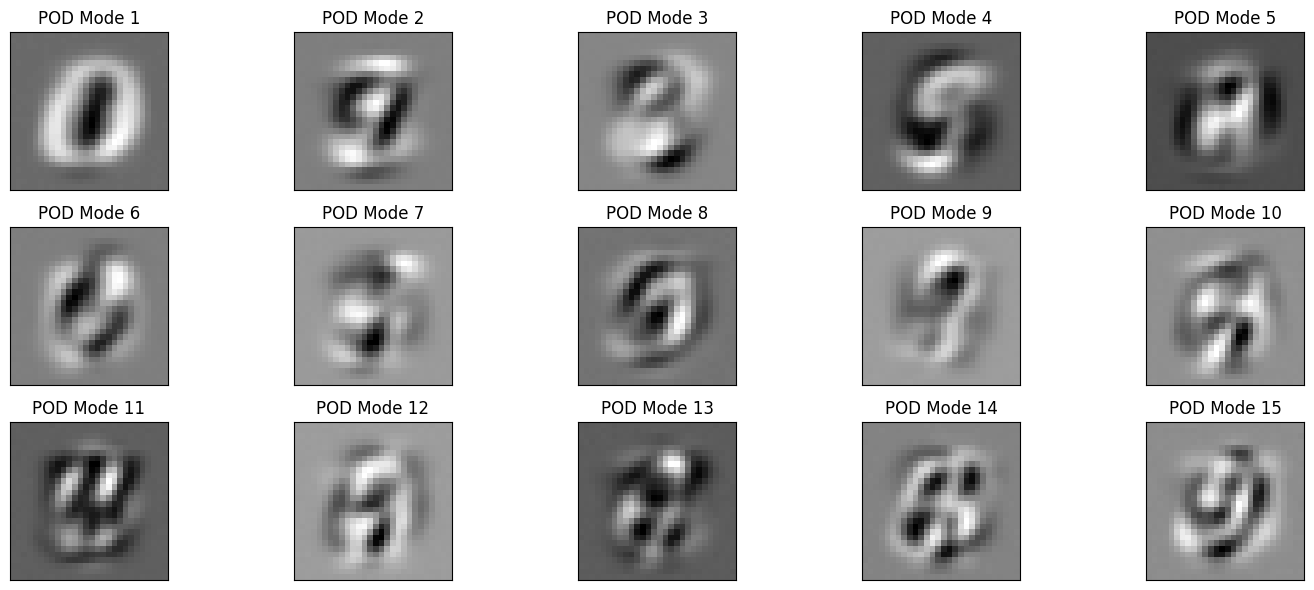

In [8]:
def plot_components_digits(pca_components, pod_components, image_shape, n_row=3, n_col=5):
    plt.figure(figsize=(15, 6))
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(pca_components[i].reshape(image_shape), cmap='gray', interpolation='nearest') # cmap='gray'
        plt.xticks(())
        plt.yticks(())
        plt.title(f'PCA Comp. {i+1}')

    plt.figure(figsize=(15, 6))
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(pod_components[i].reshape(image_shape), cmap='gray', interpolation='nearest') # cmap='gray'
        plt.xticks(())
        plt.yticks(())
        plt.title(f'POD Mode {i+1}')
    plt.tight_layout()
    plt.show()

plot_components_digits(pca_mnist.components_, V_reduced_mnist, image_shape_mnist)

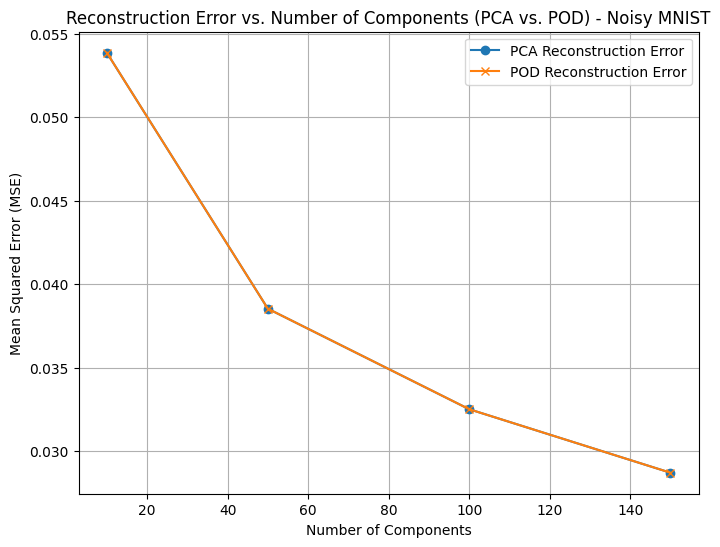

Reconstruction error (MSE) calculated and plotted for Noisy MNIST.


In [9]:
n_components_range_mnist = [10, 50, 100, 150] # Range of components for MNIST
mse_pca_mnist_list = []
mse_pod_mnist_list = []

for n_comps in n_components_range_mnist:
    # PCA for Noisy MNIST
    pca_temp_mnist = PCA(n_components=n_comps)
    pca_temp_mnist.fit(noisy_mnist_centered)
    noisy_mnist_pca_reduced_temp = pca_temp_mnist.transform(noisy_mnist_centered)
    noisy_mnist_pca_reconstructed_temp = pca_temp_mnist.inverse_transform(noisy_mnist_pca_reduced_temp)
    mse_pca_mnist = mean_squared_error(noisy_mnist_centered, noisy_mnist_pca_reconstructed_temp)
    mse_pca_mnist_list.append(mse_pca_mnist)

    # POD for Noisy MNIST
    U_temp_mnist, S_temp_mnist, V_temp_mnist = np.linalg.svd(noisy_mnist_centered)
    U_reduced_temp_mnist = U_temp_mnist[:, :n_comps]
    S_reduced_temp_mnist = np.diag(S_temp_mnist[:n_comps])
    V_reduced_temp_mnist = V_temp_mnist[:n_comps, :]
    noisy_mnist_pod_reconstructed_temp = np.dot(U_reduced_temp_mnist, np.dot(S_reduced_temp_mnist, V_reduced_temp_mnist))
    mse_pod_mnist = mean_squared_error(noisy_mnist_centered, noisy_mnist_pod_reconstructed_temp)
    mse_pod_mnist_list.append(mse_pod_mnist)

plt.figure(figsize=(8, 6))
plt.plot(n_components_range_mnist, mse_pca_mnist_list, marker='o', label='PCA Reconstruction Error')
plt.plot(n_components_range_mnist, mse_pod_mnist_list, marker='x', label='POD Reconstruction Error')
plt.xlabel('Number of Components')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Reconstruction Error vs. Number of Components (PCA vs. POD) - Noisy MNIST')
plt.legend()
plt.grid(True)
plt.show()

print("Reconstruction error (MSE) calculated and plotted for Noisy MNIST.")

In [ ]:
n_components_max = 200 # Maximum number of components to consider
n_components_range_continuous = range(1, n_components_max + 1) # Range from 1 to n_components_max
mse_pca_mnist_continuous = []
mse_pod_mnist_continuous = []

print("Calculating reconstruction error for a continuous range of components...")

for n_comps in n_components_range_continuous:
    # PCA for Noisy MNIST
    pca_temp_mnist = PCA(n_components=n_comps)
    pca_temp_mnist.fit(noisy_mnist_centered)
    noisy_mnist_pca_reduced_temp = pca_temp_mnist.transform(noisy_mnist_centered)
    noisy_mnist_pca_reconstructed_temp = pca_temp_mnist.inverse_transform(noisy_mnist_pca_reduced_temp)
    mse_pca_mnist = mean_squared_error(noisy_mnist_centered, noisy_mnist_pca_reconstructed_temp)
    mse_pca_mnist_continuous.append(mse_pca_mnist)

    # POD for Noisy MNIST
    U_temp_mnist, S_temp_mnist, V_temp_mnist = np.linalg.svd(noisy_mnist_centered)
    U_reduced_temp_mnist = U_temp_mnist[:, :n_comps]
    S_reduced_temp_mnist = np.diag(S_temp_mnist[:n_comps])
    V_reduced_temp_mnist = V_temp_mnist[:n_comps, :]
    noisy_mnist_pod_reconstructed_temp = np.dot(U_reduced_temp_mnist, np.dot(S_reduced_temp_mnist, V_reduced_temp_mnist))
    mse_pod_mnist = mean_squared_error(noisy_mnist_centered, noisy_mnist_pod_reconstructed_temp)
    mse_pod_mnist_continuous.append(mse_pod_mnist)

print("Calculation complete. Now plotting...")

plt.figure(figsize=(10, 6))
plt.plot(n_components_range_continuous, mse_pca_mnist_continuous, label='PCA Reconstruction Error')
plt.plot(n_components_range_continuous, mse_pod_mnist_continuous, label='POD Reconstruction Error')
plt.xlabel('Number of Components')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Reconstruction Error vs. Number of Components (PCA vs. POD) - Noisy MNIST (Continuous)')
plt.legend()
plt.grid(True)
plt.show()

print("Continuous reconstruction error plot generated for Noisy MNIST.")

Calculating reconstruction error for a continuous range of components...


In [ ]:
n_components_max = 200  # Maximum number of components to consider
n_components_range = range(1, n_components_max + 1)  # Range from 1 to n_components_max
mse_pca_list = []
mse_pod_list = []

print("Calculating reconstruction error for a continuous range of components...")

for i, n_comps in enumerate(n_components_range):
    # PCA
    pca_temp = PCA(n_components=n_comps)
    pca_temp.fit(faces_non_centered)
    faces_pca_reduced_temp = pca_temp.transform(faces_non_centered)
    faces_pca_reconstructed_temp = pca_temp.inverse_transform(faces_pca_reduced_temp)
    mse_pca = mean_squared_error(faces_non_centered, faces_pca_reconstructed_temp)
    mse_pca_list.append(mse_pca)

    # POD
    U_temp, S_temp, V_temp = np.linalg.svd(faces_non_centered)
    U_reduced_temp = U_temp[:, :n_comps]
    S_reduced_temp = np.diag(S_temp[:n_comps])
    V_reduced_temp = V_temp[:n_comps, :]
    faces_pod_reconstructed_temp = np.dot(U_reduced_temp, np.dot(S_reduced_temp, V_reduced_temp))
    mse_pod = mean_squared_error(faces_non_centered, faces_pod_reconstructed_temp)
    mse_pod_list.append(mse_pod)
    
    # Print progress every 20 components
    if (i+1) % 20 == 0:
        print(f"Processed {i+1}/{n_components_max} components")

print("Calculation complete. Now plotting...")

plt.figure(figsize=(12, 7))
plt.plot(n_components_range, mse_pca_list, linewidth=2, label='PCA Reconstruction Error')
plt.plot(n_components_range, mse_pod_list, linewidth=2, label='POD Reconstruction Error')
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.title('Reconstruction Error vs. Number of Components (PCA vs. POD)', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Continuous reconstruction error plot generated.")